# Text Generation with a Transformer

This notebook is based on [Text Generation with a miniature GPT](https://keras.io/examples/generative/text_generation_with_miniature_gpt/) by [Apoorv Nandan](https://twitter.com/NandanApoorv). This notebook demonstrates how to implement a language model using a small transformer network, implementing only the decoder transformer block.

## Setup the Environment

We start by setting up the environment, with many of the same packages that we have used before. The exception being the `TextVectorization` layer, which is used to produce tokens for the input text.

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
import numpy as np
import os
import re
import string
import random
import matplotlib.pyplot as plt

## Implement a Transformer Block

This section implements a transformer decoder block, which will take as input the tokens seen up to the current position and output the expected next token.To make this possible, we first implement a helper function to implement an attention mask, which prevents flow of information from future tokens to the current token.

In [28]:
def attention_mask(batch_size, n_dest, n_src, dtype):
    """
    Mask the upper half of the dot product matrix in self attention.
    This prevents flow of information from future tokens to current token.
    1's in the lower triangle, counting from the lower right corner.
    """
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)

We can visualise this attention mask as a matrix of binary values, here 1 is displayed as yellow and 0 is displayed as purple. To interpret this, the current token can be read from the row, and the input tokens being considered can be read from the columns with 1's (yellow) in them.

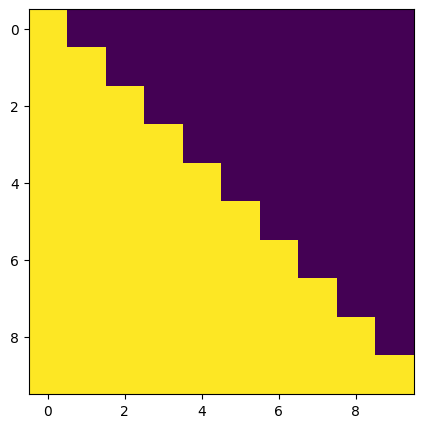

In [29]:
plt.figure(figsize=(5,5))
plt.imshow(attention_mask(10, 10, 10, tf.bool)[0, :, :])

Using the attention mask, we can implement the transformer decoder block as a Keras `Layer`. The decoder consists of a `MultiHeadAttention` layer, followed by dropout and layer normalisation layers, a feedforward network, and a second set dropout and layer normalisation layer.

In [30]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads, embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = attention_mask(batch_size, seq_len, seq_len, tf.bool)
        attention_output = self.att(inputs, inputs, attention_mask=causal_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

## Implement an Embedding Layer

To define the input to the decoder, we create an embedding layer that concatenates the output two subordinate embedding layers: one for tokens and one for token index (positions).

In [31]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## Implement the Transformer Model

Finally, we can create the transformer model, using the embedding layer, transformer block and a dense layer to translate the output of the transformer into an output that indicates the next word as a sparse coding of the size of the vocabulary, which by default is defined as the top 20,000 words in the input dataset.

In [32]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 150  # Max sequence size
embed_dim = 256  # Embedding size for each token
num_heads = 2  # Number of attention heads
feed_forward_dim = 256  # Hidden layer size in feed forward network inside transformer

In [33]:
def create_model():
    inputs = layers.Input(shape=(maxlen,), dtype=tf.int32)
    embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
    x = embedding_layer(inputs)
    transformer_block = TransformerBlock(embed_dim, num_heads, feed_forward_dim)
    x = transformer_block(x)
    outputs = layers.Dense(vocab_size)(x)
    model = keras.Model(inputs=inputs, outputs=[outputs, x])
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(
        "adam", loss=[loss_fn, None],
    )  # No loss and optimization based on word embeddings from transformer block
    return model

## Prepare the Dataset

For demonstration purposes, we will use the IMDB movie review dataset. Download the IMDB dataset and combine training and validation sets for a text
generation task.

In [34]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

In [35]:
batch_size = 128

# The dataset contains each review in a separate text file
# The text files are present in four different folders
# Create a list all files
filenames = []
directories = [
    "aclImdb/train/neg",
    "aclImdb/train/pos",
    "aclImdb/test/neg",
    "aclImdb/test/pos",
]
for dir in directories:
    for f in os.listdir(dir):
        filenames.append(os.path.join(dir, f))

print(f"{len(filenames)} files")

# Create a dataset from text files
random.shuffle(filenames)
text_ds = tf.data.TextLineDataset(filenames)
text_ds = text_ds.shuffle(buffer_size=256)
text_ds = text_ds.batch(batch_size)

50000 files


Having loaded the text into a dataset, the text needs to be standardised and vectorised, to transform it into tokens.

In [36]:
def custom_standardization(input_string):
    """ Remove html line-break tags and handle punctuation """
    lowercased = tf.strings.lower(input_string)
    stripped_html = tf.strings.regex_replace(lowercased, "<br />", " ")
    return tf.strings.regex_replace(stripped_html, f"([{string.punctuation}])", r" \1")


# Create a vectorization layer and adapt it to the text
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size - 1,
    output_mode="int",
    output_sequence_length=maxlen + 1,
)
vectorize_layer.adapt(text_ds)
vocab = vectorize_layer.get_vocabulary()  # To get words back from token indices

Finally to prepare the dataset for the language generation task, such that each vectorized sequence is split into a set of input tokens and a single output token (the last token/word in the sequence).

In [37]:
def prepare_lm_inputs_labels(text):
    """
    Shift word sequences by 1 position so that the target for position (i) is
    word at position (i+1). The model will use all words up till position (i)
    to predict the next word.
    """
    text = tf.expand_dims(text, -1)
    tokenized_sentences = vectorize_layer(text)
    x = tokenized_sentences[:, :-1]
    y = tokenized_sentences[:, 1:]
    return x, y


text_ds = text_ds.map(prepare_lm_inputs_labels)
text_ds = text_ds.prefetch(tf.data.AUTOTUNE)

## Implement a Callback to Generate Text

To monitor learning progress, we implement a `Callback` that will generate text using the current model and a prompt. To implement the callback, we start by creating a reverse lookup table for the vocabulary generated by the `TextVectorization`.

In [38]:
# Tokenize starting prompt
word_to_index = {}
for index, word in enumerate(vocab):
    word_to_index[word] = index

Next, we define a standard prompt ("this movie is") and use the lookup table to translate this into a set of tokens suitable for input to the transformer.

In [39]:
start_prompt = "this story starts"
start_tokens = [word_to_index.get(_, 1) for _ in start_prompt.split()]

The core of the `TextGenerator` uses the current model to generate a given number of tokens, one token at a time, which is appended to the input sequence. Much of the details of the code in `on_epoch_end()`, which implements this generative process deal with padding the current prompt (starting prompt and generated tokens) to equal the expected input sequence length. Having generated the given number of tokens, they are translated back into words and joined back together.

In [40]:
class TextGenerator(keras.callbacks.Callback):
    """A callback to generate text from a trained model.
    1. Feed some starting prompt to the model
    2. Predict probabilities for the next token
    3. Sample the next token and add it to the next input

    Arguments:
        max_tokens: Integer, the number of tokens to be generated after prompt.
        start_tokens: List of integers, the token indices for the starting prompt.
        index_to_word: List of strings, obtained from the TextVectorization layer.
        top_k: Integer, sample from the `top_k` token predictions.
        print_every: Integer, print after this many epochs.
    """

    def __init__(self,
                 max_tokens, start_tokens,
                 index_to_word, top_k=10,
                 print_every=1):
        self.max_tokens = max_tokens
        self.start_tokens = start_tokens
        self.index_to_word = index_to_word
        self.print_every = print_every
        self.k = top_k

    def sample_from(self, logits):
        logits, indices = tf.math.top_k(logits, k=self.k, sorted=True)
        indices = np.asarray(indices).astype("int32")
        preds = keras.activations.softmax(tf.expand_dims(logits, 0))[0]
        preds = np.asarray(preds).astype("float32")
        return np.random.choice(indices, p=preds)

    def detokenize(self, number):
        return self.index_to_word[number]

    def on_epoch_end(self, epoch, logs=None):
        start_tokens = [_ for _ in self.start_tokens]
        if (epoch + 1) % self.print_every != 0:
            return
        num_tokens_generated = 0
        tokens_generated = []
        while num_tokens_generated <= self.max_tokens:
            pad_len = maxlen - len(start_tokens)
            sample_index = len(start_tokens) - 1
            if pad_len < 0:
                x = start_tokens[:maxlen]
                sample_index = maxlen - 1
            elif pad_len > 0:
                x = start_tokens + [0] * pad_len
            else:
                x = start_tokens
            x = np.array([x])
            y, _ = self.model.predict(x)
            sample_token = self.sample_from(y[0][sample_index])
            tokens_generated.append(sample_token)
            start_tokens.append(sample_token)
            num_tokens_generated = len(tokens_generated)
        txt = " ".join(
            [self.detokenize(_) for _ in self.start_tokens + tokens_generated]
        )
        print(f"generated text:\n{txt}\n")

An instance of the callback is initialised with the desired length of the generated texts, the starting prompt (as tokens), and the vocabulary to use.

In [41]:
num_tokens_generated = 40

text_gen_callback = TextGenerator(num_tokens_generated, start_tokens, vocab)

## Train the model

Finally, the model can be created and trained.

**Note:** The training should preferably be executed on a GPU runtime. The number of epochs has been limited to 10 for the purposes of this demonstration but the model would benefit from further training.

In [42]:
model = create_model()
model.get_layer(index=2).ffn.summary()

model.fit(text_ds, verbose=2, epochs=10, callbacks=[text_gen_callback])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 150, 256)       │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 150, 256)       │        65,792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,584 (514.00 KB)

 Trainable params: 131,584 (514.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

## Improving the Model

Here are some ideas for improving the model that you might want to try:

- Increase the number of heads used to attend to the input sequences (the implementation above uses two heads, but could easily be adapted to use more)
- Experiment with different embedding dimensions (the current implementation uses 256 but could be smaller if more heads are being used)
- Add more decoder transformer layers
- Increase the size of the vocabulary

## Tutorial Assignment

Use a transformer, like the one above, to generate text based on a different dataset; preferably, one based on a creative writing.

For example, text files from Project Gutenberg, preprocessed in the same way that you did for the previous tutorial on [Generating Text with LSTM](https://colab.research.google.com/drive/1o6nXejUdGQtEgBahnrRnZTevl6hJv3wo?usp=sharing), could be used to substitute the IMDB input files used above. Transformers, however, typically need a large dataset to be effective. So consider processing a number of books by a single author.

**Note:** An alternative/simpler implementation of the above can be found at [5-Line GPT-Style Text Generation in Python with TensorFlow/Keras](https://stackabuse.com/gpt-style-text-generation-in-python-with-tensorflowkeras/). This alternative implementation takes advantage of the KeraNLP library, and provides an example of how to use Project Gutenberg texts (with a simple/crude approach to removing the Gutenberg preface text).

# Assignment 5
Volodymyr Kalinin

In this assignment, I have increased the number of heads to 8, set the dimentions to 192, increased the number of decoder transformer layers to 4, and have increased the number of epochs to 20. After that model's accuracy and coherence has increased. However, after changing the dataset, I have encoutered issues with the model training too slow and the text being generated incoherently, so I had to reverse the changes transformer layers back to 1, increase the max sequence size to 150. As the training dataset, I've chosen Lev Tolstoy's 6 books I found on Project Gutenberg. The model performs well, generated Lev-Tolstoy-styled text. In order for the model to train, the user needs to import the folder with books into the projects directory.